# Feature Engineering
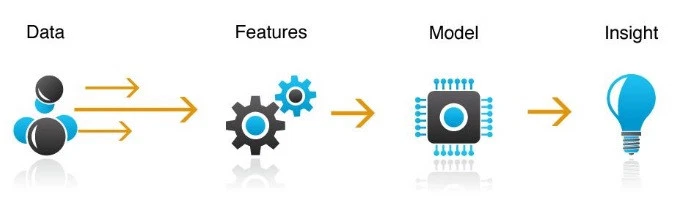
Image:  https://venturebeat.com/2018/07/21/why-your-machine-learning-team-needs-better-feature-engineering-skills/

# Setup

In [1]:
!conda install featuretools --yes

Solving environment: \ 
  - https://repo.continuum.io/pkgs/main/osx-64::cvxcanon-0.1.1-py36h6440ff4_0
  - defaults::cvxcanon-0.1.1-py36h6440ff4done

# All requested packages already installed.



In [2]:
import featuretools as ft
import pandas as pd
import numpy as np

import vtreat
import catboost as cat
import feature_engine as fe

from feature_engine import categorical_encoders as ce
from feature_engine import discretisers as dsc

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix

# Data

In [3]:
flightDF  = pd.read_csv('./flight-delays/flights.csv')
airportDF = pd.read_csv('./flight-delays/airports.csv')
airlineDF = pd.read_csv('./flight-delays/airlines.csv')

/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
flightDF.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object

In [5]:
flightDF.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
airportDF.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [7]:
airlineDF.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


# Processing
* Toss numeric airport values for this demo

In [8]:
flightDF = flightDF[(flightDF.ORIGIN_AIRPORT.str.len() == 3) & (flightDF.DESTINATION_AIRPORT.str.len() == 3)]

## Date Time

In [9]:
flightDF['DATE'] = pd.to_datetime(flightDF[['YEAR', 'MONTH', 'DAY']])

## Columns

In [10]:
keepCols = ['MONTH',
            'DAY_OF_WEEK',
            'AIRLINE',
            'ORIGIN_AIRPORT',
            'DESTINATION_AIRPORT',
            'SCHEDULED_DEPARTURE',
            'SCHEDULED_ARRIVAL',
            'SCHEDULED_TIME',
            'DISTANCE',
            'ARRIVAL_DELAY',
            'CANCELLED'
]
df = flightDF[keepCols].copy()

airlineDF = airlineDF[['IATA_CODE']]
airportDF = airportDF[['IATA_CODE']]

## Missing Data

In [11]:
missingDF = pd.DataFrame(df.isna().mean().round(4) * 100)
missingDF.reset_index().rename(columns={'index': 'Feature', 0: 'Percent Missing'})

,Feature,Percent Missing
0,MONTH,0.00
1,DAY_OF_WEEK,0.00
2,AIRLINE,0.00
3,ORIGIN_AIRPORT,0.00
4,DESTINATION_AIRPORT,0.00
5,SCHEDULED_DEPARTURE,0.00
6,SCHEDULED_ARRIVAL,0.00
7,SCHEDULED_TIME,0.00
8,DISTANCE,0.00
9,ARRIVAL_DELAY,1.91


In [12]:
df = df.dropna()

## Classification

In [13]:
## Balance Classes
RECORDS=1000000
delay  = df[df.ARRIVAL_DELAY > 0].sample(RECORDS)
ontime = df[df.ARRIVAL_DELAY <= 0].sample(RECORDS)
data = pd.concat([delay, ontime])

In [14]:
data['CLASS'] = np.where(data.ARRIVAL_DELAY <= 0, 'ONTIME', 'DELAY')

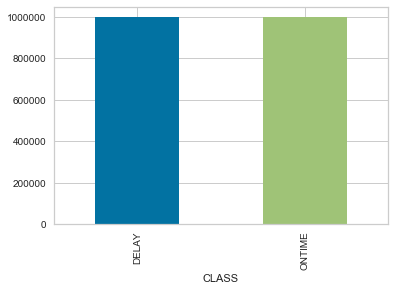

In [15]:
data.groupby('CLASS').size().plot.bar()

In [16]:
X_data = data.drop(columns=['CLASS', 'ARRIVAL_DELAY'])
y_data = data['CLASS']
y_data = np.where(y_data == 'ONTIME', 0, 1)

# Error Metric

In [17]:
def measureErrors(y, y_hat):
    accuracy = accuracy_score(y, y_hat)
    print('Accuracy', accuracy)
    print('Confusion Matrix')
    print(confusion_matrix(y, y_hat))
    print('Classification Report')
    print(classification_report(y_hat, y))
    return accuracy

resultsDF = pd.DataFrame(columns=['Accuracy', 'Features'])

# Baseline

## Training Data

In [103]:
X_data_base = X_data.copy()
y_data_base = y_data.copy()

X_train_base, X_test_base, y_train_base, y_test_base = \
    train_test_split(X_data_base, y_data_base, test_size=0.2, random_state=1337)

## Fit Model

In [104]:
catModel = cat.CatBoostClassifier(iterations=500, 
                          depth=6, 
                          learning_rate=0.1, 
                          early_stopping_rounds=5,
                          loss_function='Logloss')

In [105]:
X_train_cb, X_val_cb, y_train_cb, y_val_cb = \
    train_test_split(X_train_base, y_train_base, test_size=0.2, random_state=1337)

In [106]:
cat_idx = X_train_cb.columns.get_indexer(X_train_cb.select_dtypes('object').columns)

train_pool = cat.Pool(X_train_cb, y_train_cb, cat_features=cat_idx)
val_pool   = cat.Pool(X_val_cb, y_val_cb, cat_features=cat_idx)
test_pool  = cat.Pool(X_test_base, cat_features=cat_idx) 

In [107]:
catModel.fit(train_pool, eval_set=val_pool)

0:	learn: 0.6900834	test: 0.6900357	best: 0.6900357 (0)	total: 806ms	remaining: 6m 42s
1:	learn: 0.6876322	test: 0.6875446	best: 0.6875446 (1)	total: 1.58s	remaining: 6m 33s
2:	learn: 0.6855616	test: 0.6854349	best: 0.6854349 (2)	total: 2.26s	remaining: 6m 14s
3:	learn: 0.6837807	test: 0.6836026	best: 0.6836026 (3)	total: 2.89s	remaining: 5m 57s
4:	learn: 0.6822640	test: 0.6820211	best: 0.6820211 (4)	total: 3.51s	remaining: 5m 47s
5:	learn: 0.6809594	test: 0.6806604	best: 0.6806604 (5)	total: 4.15s	remaining: 5m 41s
6:	learn: 0.6798615	test: 0.6795097	best: 0.6795097 (6)	total: 4.83s	remaining: 5m 40s
7:	learn: 0.6788002	test: 0.6784126	best: 0.6784126 (7)	total: 5.6s	remaining: 5m 44s
8:	learn: 0.6775452	test: 0.6771211	best: 0.6771211 (8)	total: 6.3s	remaining: 5m 43s
9:	learn: 0.6765223	test: 0.6760346	best: 0.6760346 (9)	total: 6.94s	remaining: 5m 39s
10:	learn: 0.6756527	test: 0.6751207	best: 0.6751207 (10)	total: 7.49s	remaining: 5m 33s
11:	learn: 0.6749342	test: 0.6743454	best: 

93:	learn: 0.6604088	test: 0.6586191	best: 0.6586191 (93)	total: 59s	remaining: 4m 14s
94:	learn: 0.6603710	test: 0.6585803	best: 0.6585803 (94)	total: 59.6s	remaining: 4m 13s
95:	learn: 0.6602927	test: 0.6585007	best: 0.6585007 (95)	total: 1m	remaining: 4m 13s
96:	learn: 0.6602435	test: 0.6584592	best: 0.6584592 (96)	total: 1m	remaining: 4m 13s
97:	learn: 0.6601919	test: 0.6584197	best: 0.6584197 (97)	total: 1m 1s	remaining: 4m 12s
98:	learn: 0.6601309	test: 0.6583572	best: 0.6583572 (98)	total: 1m 2s	remaining: 4m 12s
99:	learn: 0.6600809	test: 0.6583169	best: 0.6583169 (99)	total: 1m 2s	remaining: 4m 11s
100:	learn: 0.6600573	test: 0.6582960	best: 0.6582960 (100)	total: 1m 3s	remaining: 4m 10s
101:	learn: 0.6600278	test: 0.6582628	best: 0.6582628 (101)	total: 1m 4s	remaining: 4m 9s
102:	learn: 0.6599844	test: 0.6582167	best: 0.6582167 (102)	total: 1m 4s	remaining: 4m 8s
103:	learn: 0.6599221	test: 0.6581637	best: 0.6581637 (103)	total: 1m 5s	remaining: 4m 8s
104:	learn: 0.6598657	te

183:	learn: 0.6570341	test: 0.6554430	best: 0.6554430 (183)	total: 1m 54s	remaining: 3m 17s
184:	learn: 0.6570082	test: 0.6554249	best: 0.6554249 (184)	total: 1m 55s	remaining: 3m 16s
185:	learn: 0.6569847	test: 0.6554048	best: 0.6554048 (185)	total: 1m 56s	remaining: 3m 16s
186:	learn: 0.6569292	test: 0.6553502	best: 0.6553502 (186)	total: 1m 56s	remaining: 3m 15s
187:	learn: 0.6568972	test: 0.6553264	best: 0.6553264 (187)	total: 1m 57s	remaining: 3m 14s
188:	learn: 0.6568722	test: 0.6553077	best: 0.6553077 (188)	total: 1m 58s	remaining: 3m 14s
189:	learn: 0.6568451	test: 0.6552855	best: 0.6552855 (189)	total: 1m 58s	remaining: 3m 13s
190:	learn: 0.6567920	test: 0.6552329	best: 0.6552329 (190)	total: 1m 59s	remaining: 3m 13s
191:	learn: 0.6567331	test: 0.6551706	best: 0.6551706 (191)	total: 1m 59s	remaining: 3m 12s
192:	learn: 0.6567195	test: 0.6551612	best: 0.6551612 (192)	total: 2m	remaining: 3m 11s
193:	learn: 0.6566939	test: 0.6551430	best: 0.6551430 (193)	total: 2m 1s	remaining: 

273:	learn: 0.6548028	test: 0.6536162	best: 0.6536162 (273)	total: 2m 48s	remaining: 2m 18s
274:	learn: 0.6547762	test: 0.6535964	best: 0.6535964 (274)	total: 2m 48s	remaining: 2m 18s
275:	learn: 0.6547566	test: 0.6535842	best: 0.6535842 (275)	total: 2m 49s	remaining: 2m 17s
276:	learn: 0.6547291	test: 0.6535627	best: 0.6535627 (276)	total: 2m 50s	remaining: 2m 16s
277:	learn: 0.6547099	test: 0.6535484	best: 0.6535484 (277)	total: 2m 50s	remaining: 2m 16s
278:	learn: 0.6546798	test: 0.6535138	best: 0.6535138 (278)	total: 2m 51s	remaining: 2m 15s
279:	learn: 0.6546675	test: 0.6535048	best: 0.6535048 (279)	total: 2m 51s	remaining: 2m 15s
280:	learn: 0.6546508	test: 0.6534927	best: 0.6534927 (280)	total: 2m 52s	remaining: 2m 14s
281:	learn: 0.6546403	test: 0.6534893	best: 0.6534893 (281)	total: 2m 53s	remaining: 2m 13s
282:	learn: 0.6546231	test: 0.6534759	best: 0.6534759 (282)	total: 2m 53s	remaining: 2m 13s
283:	learn: 0.6546135	test: 0.6534684	best: 0.6534684 (283)	total: 2m 54s	remain

363:	learn: 0.6531823	test: 0.6523412	best: 0.6523412 (363)	total: 3m 41s	remaining: 1m 22s
364:	learn: 0.6531671	test: 0.6523292	best: 0.6523292 (364)	total: 3m 42s	remaining: 1m 22s
365:	learn: 0.6531527	test: 0.6523182	best: 0.6523182 (365)	total: 3m 43s	remaining: 1m 21s
366:	learn: 0.6531347	test: 0.6523046	best: 0.6523046 (366)	total: 3m 43s	remaining: 1m 21s
367:	learn: 0.6531207	test: 0.6522920	best: 0.6522920 (367)	total: 3m 44s	remaining: 1m 20s
368:	learn: 0.6531116	test: 0.6522838	best: 0.6522838 (368)	total: 3m 44s	remaining: 1m 19s
369:	learn: 0.6531027	test: 0.6522789	best: 0.6522789 (369)	total: 3m 45s	remaining: 1m 19s
370:	learn: 0.6530845	test: 0.6522701	best: 0.6522701 (370)	total: 3m 46s	remaining: 1m 18s
371:	learn: 0.6530716	test: 0.6522604	best: 0.6522604 (371)	total: 3m 46s	remaining: 1m 18s
372:	learn: 0.6530428	test: 0.6522313	best: 0.6522313 (372)	total: 3m 47s	remaining: 1m 17s
373:	learn: 0.6530346	test: 0.6522239	best: 0.6522239 (373)	total: 3m 48s	remain

454:	learn: 0.6519075	test: 0.6514389	best: 0.6514389 (454)	total: 4m 35s	remaining: 27.2s
455:	learn: 0.6518927	test: 0.6514337	best: 0.6514337 (455)	total: 4m 35s	remaining: 26.6s
456:	learn: 0.6518839	test: 0.6514278	best: 0.6514278 (456)	total: 4m 36s	remaining: 26s
457:	learn: 0.6518668	test: 0.6514212	best: 0.6514212 (457)	total: 4m 36s	remaining: 25.4s
458:	learn: 0.6518542	test: 0.6514116	best: 0.6514116 (458)	total: 4m 37s	remaining: 24.8s
459:	learn: 0.6518455	test: 0.6514069	best: 0.6514069 (459)	total: 4m 38s	remaining: 24.2s
460:	learn: 0.6518341	test: 0.6513969	best: 0.6513969 (460)	total: 4m 38s	remaining: 23.6s
461:	learn: 0.6518268	test: 0.6513955	best: 0.6513955 (461)	total: 4m 39s	remaining: 23s
462:	learn: 0.6518139	test: 0.6513868	best: 0.6513868 (462)	total: 4m 39s	remaining: 22.4s
463:	learn: 0.6517970	test: 0.6513732	best: 0.6513732 (463)	total: 4m 40s	remaining: 21.8s
464:	learn: 0.6517801	test: 0.6513565	best: 0.6513565 (464)	total: 4m 41s	remaining: 21.2s
465

## Predict Model

In [108]:
pred = catModel.predict(test_pool)

In [109]:
acc = measureErrors(pred, y_test_base)
resultsDF.loc['Baseline'] = [acc, len(X_train_base.columns)]

Accuracy 0.6156125
Confusion Matrix
[[120863  74559]
 [ 79196 125382]]
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.60      0.61    200059
           1       0.61      0.63      0.62    199941

    accuracy                           0.62    400000
   macro avg       0.62      0.62      0.62    400000
weighted avg       0.62      0.62      0.62    400000



## Importance

In [110]:
importanceDF = pd.DataFrame(columns=['Feature', 'Importance'])
importanceDF['Feature'] = X_train_base.columns
importanceDF['Importance'] = catModel.feature_importances_
importanceDF = importanceDF.sort_values('Importance', ascending=False)
importanceDF

,Feature,Importance
0,MONTH,22.686677
2,AIRLINE,16.774643
5,SCHEDULED_DEPARTURE,15.402206
3,ORIGIN_AIRPORT,9.509392
1,DAY_OF_WEEK,8.883186
4,DESTINATION_AIRPORT,8.500194
6,SCHEDULED_ARRIVAL,8.008266
7,SCHEDULED_TIME,5.699636
8,DISTANCE,4.535801
9,CANCELLED,0.000000


# Feature Engine
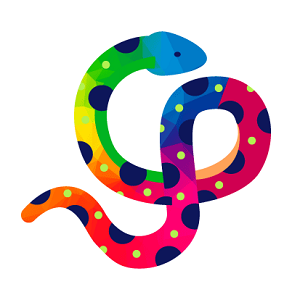
Source:  https://feature-engine.readthedocs.io/en/latest/#

## Training Data

In [86]:
X_data_fe = X_data.copy()
y_data_fe = y_data.copy()

X_data_fe['MONTH']       = X_data_fe.astype(str)
X_data_fe['DAY_OF_WEEK'] = X_data_fe.astype(str)

X_train_fe, X_test_fe, y_train_fe, y_test_fe = \
    train_test_split(X_data_fe, y_data_fe, test_size=0.2, random_state=1337)

## Interaction - Route
* Let's pair up origin and destination to get route

In [87]:
X_train_fe['ROUTE'] = X_train_fe['ORIGIN_AIRPORT'] + '->' + X_train_fe['DESTINATION_AIRPORT']
X_test_fe['ROUTE']  = X_test_fe['ORIGIN_AIRPORT']  + '->' + X_test_fe['DESTINATION_AIRPORT']

In [88]:
X_train_fe.head()

,MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,DISTANCE,CANCELLED,ROUTE
2660368,6,6,EV,BPT,DFW,1115,1227,72.0,270,0,BPT->DFW
1264954,3,3,OO,PSP,PHX,1415,1523,68.0,261,0,PSP->PHX
2480846,6,6,NK,DFW,FLL,1638,2025,167.0,1119,0,DFW->FLL
2532925,6,6,OO,EAU,ORD,1851,2008,77.0,268,0,EAU->ORD
292432,1,1,UA,ORD,SJU,825,1505,280.0,2072,0,ORD->SJU


## Bin Departure / Arrival
* We have the actual time, but let's broadly classify the time range

In [89]:
# We're appending
X_train_fe['SCHEDULED_DEPARTURE_ORIG'] = X_train_fe['SCHEDULED_DEPARTURE']
X_test_fe['SCHEDULED_DEPARTURE_ORIG']  = X_test_fe['SCHEDULED_DEPARTURE']
X_train_fe['SCHEDULED_ARRIVAL_ORIG']   = X_train_fe['SCHEDULED_ARRIVAL']
X_test_fe['SCHEDULED_ARRIVAL_ORIG']    = X_test_fe['SCHEDULED_ARRIVAL']

disc = dsc.EqualWidthDiscretiser(bins=6, variables=['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'])
encoder = disc.fit(X_train_fe)

# Convert 
X_train_fe = disc.transform(X_train_fe)
X_test_fe  = disc.transform(X_test_fe)

In [90]:
X_train_fe.head()

,MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,DISTANCE,CANCELLED,ROUTE,SCHEDULED_DEPARTURE_ORIG,SCHEDULED_ARRIVAL_ORIG
2660368,6,6,EV,BPT,DFW,2,3,72.0,270,0,BPT->DFW,1115,1227
1264954,3,3,OO,PSP,PHX,3,3,68.0,261,0,PSP->PHX,1415,1523
2480846,6,6,NK,DFW,FLL,4,5,167.0,1119,0,DFW->FLL,1638,2025
2532925,6,6,OO,EAU,ORD,4,5,77.0,268,0,EAU->ORD,1851,2008
292432,1,1,UA,ORD,SJU,2,3,280.0,2072,0,ORD->SJU,825,1505


## Weight of Evidence Encoding
* Ratio of probabilities log ( P[1] / P[0] )
* We can replace existing data or append

In [91]:
def WOE(df, column, y):
    t = df.copy()
    t['CLASS'] = y
    t = t.groupby([column])['CLASS'].mean()
    t = pd.concat([t, 1-t], axis=1)
    t.columns=['p1', 'p0']

    assert t.loc[t['p0'] ==0, :].empty
    assert t.loc[t['p1'] ==0, :].empty
    encoding = np.log(t.p1 / t.p0).to_dict()
    return encoding

def encodeWOE(column, train, test, y, replace=True):
    target = column if replace == True else column + '_WOE'
    encoder = WOE(train, column, y)
    train[target] = train[column].map(encoder)
    test[target] = test[column].map(encoder)
    
encodeWOE('DAY_OF_WEEK', X_train_fe, X_test_fe, y_train_fe, False)
encodeWOE('MONTH',       X_train_fe, X_test_fe, y_train_fe, False)
encodeWOE('AIRLINE',     X_train_fe, X_test_fe, y_train_fe, False)
encodeWOE('SCHEDULED_DEPARTURE', X_train_fe, X_test_fe, y_train_fe, False)
encodeWOE('SCHEDULED_ARRIVAL',   X_train_fe, X_test_fe, y_train_fe, False)

In [92]:
X_train_fe.head()

,MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,DISTANCE,CANCELLED,ROUTE,SCHEDULED_DEPARTURE_ORIG,SCHEDULED_ARRIVAL_ORIG,DAY_OF_WEEK_WOE,MONTH_WOE,AIRLINE_WOE,SCHEDULED_DEPARTURE_WOE,SCHEDULED_ARRIVAL_WOE
2660368,6,6,EV,BPT,DFW,2,3,72.0,270,0,BPT->DFW,1115,1227,0.198417,0.198417,0.063603,-0.179048,-0.088404
1264954,3,3,OO,PSP,PHX,3,3,68.0,261,0,PSP->PHX,1415,1523,0.063848,0.063848,0.077332,0.089344,-0.088404
2480846,6,6,NK,DFW,FLL,4,5,167.0,1119,0,DFW->FLL,1638,2025,0.198417,0.198417,0.529309,0.290102,0.301622
2532925,6,6,OO,EAU,ORD,4,5,77.0,268,0,EAU->ORD,1851,2008,0.198417,0.198417,0.077332,0.290102,0.301622
292432,1,1,UA,ORD,SJU,2,3,280.0,2072,0,ORD->SJU,825,1505,0.121753,0.121753,0.028769,-0.179048,-0.088404


## Mean Categorical Encoding

In [93]:
def meanCategory(df, column, y):
    t = df.copy()
    t['CLASS'] = y
    t = t.groupby([column])['CLASS'].mean()
    encoding = t.to_dict()
    return encoding

def encodeMeanCategory(column, train, test, y, replace=True):
    target = column if replace == True else column + '_MEAN'
    encoder = meanCategory(train, column, y)
    train[target] = train[column].map(encoder)
    test[target] = test[column].map(encoder)
    
encodeMeanCategory('MONTH',               X_train_fe, X_test_fe, y_train_fe, False)
encodeMeanCategory('DAY_OF_WEEK',         X_train_fe, X_test_fe, y_train_fe, False)
encodeMeanCategory('ORIGIN_AIRPORT',      X_train_fe, X_test_fe, y_train_fe, False)
encodeMeanCategory('DESTINATION_AIRPORT', X_train_fe, X_test_fe, y_train_fe, False)
encodeMeanCategory('AIRLINE',             X_train_fe, X_test_fe, y_train_fe, False)
encodeMeanCategory('SCHEDULED_DEPARTURE', X_train_fe, X_test_fe, y_train_fe, False)
encodeMeanCategory('SCHEDULED_ARRIVAL',   X_train_fe, X_test_fe, y_train_fe, False)
encodeMeanCategory('ROUTE',               X_train_fe, X_test_fe, y_train_fe, False)

In [94]:
X_train_fe.head()

,MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,DISTANCE,CANCELLED,...,SCHEDULED_DEPARTURE_WOE,SCHEDULED_ARRIVAL_WOE,MONTH_MEAN,DAY_OF_WEEK_MEAN,ORIGIN_AIRPORT_MEAN,DESTINATION_AIRPORT_MEAN,AIRLINE_MEAN,SCHEDULED_DEPARTURE_MEAN,SCHEDULED_ARRIVAL_MEAN,ROUTE_MEAN
2660368,6,6,EV,BPT,DFW,2,3,72.0,270,0,...,-0.179048,-0.088404,0.549442,0.549442,0.579861,0.485013,0.515895,0.455357,0.477913,0.579861
1264954,3,3,OO,PSP,PHX,3,3,68.0,261,0,...,0.089344,-0.088404,0.515957,0.515957,0.497985,0.504521,0.519323,0.522321,0.477913,0.581308
2480846,6,6,NK,DFW,FLL,4,5,167.0,1119,0,...,0.290102,0.301622,0.549442,0.549442,0.527499,0.519394,0.629322,0.572021,0.574839,0.604369
2532925,6,6,OO,EAU,ORD,4,5,77.0,268,0,...,0.290102,0.301622,0.549442,0.549442,0.412088,0.505807,0.519323,0.572021,0.574839,0.412088
292432,1,1,UA,ORD,SJU,2,3,280.0,2072,0,...,-0.179048,-0.088404,0.530401,0.530401,0.539456,0.553183,0.507192,0.455357,0.477913,0.527869


## Other Common Techniques
* Handling Missing Data
 * Imputing (Mean / Median)
 * Flag and Impute
* Categorical Data
 * Rare Levels
 * OHE
 * Label
 * Frequency
 * Count
* Numerical
 * Taking Log / Power Transformation
 * Discretizing
* Handling Outliers
 * Winsorizing
 * Capping
* Dates
* Spatial

## Fit Model

In [95]:
catModel = cat.CatBoostClassifier(iterations=500, 
                          depth=6, 
                          learning_rate=0.1, 
                          early_stopping_rounds=5,
                          loss_function='Logloss')

In [96]:
X_train_cb, X_val_cb, y_train_cb, y_val_cb = \
    train_test_split(X_train_fe, y_train_fe, test_size=0.2, random_state=1337)

In [97]:
cat_idx = X_train_cb.columns.get_indexer(X_train_cb.select_dtypes('object').columns)

train_pool = cat.Pool(X_train_cb, y_train_cb, cat_features=cat_idx)
val_pool   = cat.Pool(X_val_cb, y_val_cb, cat_features=cat_idx)
test_pool  = cat.Pool(X_test_fe, cat_features=cat_idx) 

In [98]:
catModel.fit(train_pool, eval_set=val_pool)

0:	learn: 0.6887768	test: 0.6886859	best: 0.6886859 (0)	total: 1.14s	remaining: 9m 26s
1:	learn: 0.6852848	test: 0.6851348	best: 0.6851348 (1)	total: 2.17s	remaining: 8m 59s
2:	learn: 0.6820880	test: 0.6818394	best: 0.6818394 (2)	total: 3.12s	remaining: 8m 36s
3:	learn: 0.6795701	test: 0.6792429	best: 0.6792429 (3)	total: 4.12s	remaining: 8m 31s
4:	learn: 0.6773289	test: 0.6769532	best: 0.6769532 (4)	total: 5.1s	remaining: 8m 24s
5:	learn: 0.6754463	test: 0.6750309	best: 0.6750309 (5)	total: 6.11s	remaining: 8m 22s
6:	learn: 0.6737985	test: 0.6733295	best: 0.6733295 (6)	total: 7.19s	remaining: 8m 26s
7:	learn: 0.6722625	test: 0.6717408	best: 0.6717408 (7)	total: 8s	remaining: 8m 12s
8:	learn: 0.6710468	test: 0.6704966	best: 0.6704966 (8)	total: 9.01s	remaining: 8m 11s
9:	learn: 0.6699234	test: 0.6693168	best: 0.6693168 (9)	total: 10s	remaining: 8m 12s
10:	learn: 0.6690134	test: 0.6683571	best: 0.6683571 (10)	total: 10.9s	remaining: 8m 3s
11:	learn: 0.6678453	test: 0.6670752	best: 0.667

93:	learn: 0.6551907	test: 0.6530554	best: 0.6530554 (93)	total: 1m 25s	remaining: 6m 11s
94:	learn: 0.6551667	test: 0.6530319	best: 0.6530319 (94)	total: 1m 26s	remaining: 6m 10s
95:	learn: 0.6551339	test: 0.6529940	best: 0.6529940 (95)	total: 1m 27s	remaining: 6m 10s
96:	learn: 0.6550977	test: 0.6529585	best: 0.6529585 (96)	total: 1m 28s	remaining: 6m 8s
97:	learn: 0.6550789	test: 0.6529388	best: 0.6529388 (97)	total: 1m 29s	remaining: 6m 7s
98:	learn: 0.6550516	test: 0.6529049	best: 0.6529049 (98)	total: 1m 30s	remaining: 6m 7s
99:	learn: 0.6550253	test: 0.6528847	best: 0.6528847 (99)	total: 1m 31s	remaining: 6m 6s
100:	learn: 0.6550072	test: 0.6528669	best: 0.6528669 (100)	total: 1m 32s	remaining: 6m 5s
101:	learn: 0.6549591	test: 0.6528230	best: 0.6528230 (101)	total: 1m 33s	remaining: 6m 4s
102:	learn: 0.6549322	test: 0.6527981	best: 0.6527981 (102)	total: 1m 34s	remaining: 6m 3s
103:	learn: 0.6549035	test: 0.6527766	best: 0.6527766 (103)	total: 1m 35s	remaining: 6m 2s
104:	learn

183:	learn: 0.6530631	test: 0.6510960	best: 0.6510960 (183)	total: 2m 49s	remaining: 4m 51s
184:	learn: 0.6530399	test: 0.6510654	best: 0.6510654 (184)	total: 2m 50s	remaining: 4m 50s
185:	learn: 0.6530298	test: 0.6510571	best: 0.6510571 (185)	total: 2m 51s	remaining: 4m 49s
186:	learn: 0.6530038	test: 0.6510371	best: 0.6510371 (186)	total: 2m 52s	remaining: 4m 48s
187:	learn: 0.6529852	test: 0.6510254	best: 0.6510254 (187)	total: 2m 53s	remaining: 4m 47s
188:	learn: 0.6529590	test: 0.6510062	best: 0.6510062 (188)	total: 2m 54s	remaining: 4m 46s
189:	learn: 0.6529436	test: 0.6509935	best: 0.6509935 (189)	total: 2m 55s	remaining: 4m 45s
190:	learn: 0.6529313	test: 0.6509867	best: 0.6509867 (190)	total: 2m 56s	remaining: 4m 44s
191:	learn: 0.6529111	test: 0.6509736	best: 0.6509736 (191)	total: 2m 57s	remaining: 4m 43s
192:	learn: 0.6528940	test: 0.6509620	best: 0.6509620 (192)	total: 2m 57s	remaining: 4m 42s
193:	learn: 0.6528820	test: 0.6509494	best: 0.6509494 (193)	total: 2m 59s	remain

273:	learn: 0.6515529	test: 0.6499674	best: 0.6499674 (273)	total: 4m 15s	remaining: 3m 30s
274:	learn: 0.6515405	test: 0.6499611	best: 0.6499611 (274)	total: 4m 16s	remaining: 3m 29s
275:	learn: 0.6515287	test: 0.6499515	best: 0.6499515 (275)	total: 4m 17s	remaining: 3m 29s
276:	learn: 0.6515064	test: 0.6499347	best: 0.6499347 (276)	total: 4m 18s	remaining: 3m 28s
277:	learn: 0.6514864	test: 0.6499212	best: 0.6499212 (277)	total: 4m 19s	remaining: 3m 27s
278:	learn: 0.6514680	test: 0.6499098	best: 0.6499098 (278)	total: 4m 20s	remaining: 3m 26s
279:	learn: 0.6514541	test: 0.6499041	best: 0.6499041 (279)	total: 4m 21s	remaining: 3m 25s
280:	learn: 0.6514439	test: 0.6498971	best: 0.6498971 (280)	total: 4m 22s	remaining: 3m 24s
281:	learn: 0.6514385	test: 0.6498965	best: 0.6498965 (281)	total: 4m 23s	remaining: 3m 23s
282:	learn: 0.6514282	test: 0.6498923	best: 0.6498923 (282)	total: 4m 24s	remaining: 3m 22s
283:	learn: 0.6514218	test: 0.6498870	best: 0.6498870 (283)	total: 4m 25s	remain

363:	learn: 0.6504592	test: 0.6492851	best: 0.6492851 (363)	total: 5m 41s	remaining: 2m 7s
364:	learn: 0.6504543	test: 0.6492823	best: 0.6492823 (364)	total: 5m 42s	remaining: 2m 6s
365:	learn: 0.6504467	test: 0.6492755	best: 0.6492755 (365)	total: 5m 43s	remaining: 2m 5s
366:	learn: 0.6504354	test: 0.6492678	best: 0.6492678 (366)	total: 5m 44s	remaining: 2m 4s
367:	learn: 0.6504312	test: 0.6492649	best: 0.6492649 (367)	total: 5m 45s	remaining: 2m 3s
368:	learn: 0.6504123	test: 0.6492517	best: 0.6492517 (368)	total: 5m 46s	remaining: 2m 2s
369:	learn: 0.6504073	test: 0.6492460	best: 0.6492460 (369)	total: 5m 47s	remaining: 2m 2s
370:	learn: 0.6503992	test: 0.6492410	best: 0.6492410 (370)	total: 5m 48s	remaining: 2m 1s
371:	learn: 0.6503949	test: 0.6492388	best: 0.6492388 (371)	total: 5m 48s	remaining: 2m
372:	learn: 0.6503916	test: 0.6492387	best: 0.6492387 (372)	total: 5m 49s	remaining: 1m 59s
373:	learn: 0.6503840	test: 0.6492367	best: 0.6492367 (373)	total: 5m 50s	remaining: 1m 58s


453:	learn: 0.6496225	test: 0.6488582	best: 0.6488582 (453)	total: 7m 5s	remaining: 43.1s
454:	learn: 0.6496158	test: 0.6488566	best: 0.6488566 (454)	total: 7m 6s	remaining: 42.1s
455:	learn: 0.6496037	test: 0.6488475	best: 0.6488475 (455)	total: 7m 6s	remaining: 41.2s
456:	learn: 0.6495999	test: 0.6488452	best: 0.6488452 (456)	total: 7m 7s	remaining: 40.3s
457:	learn: 0.6495920	test: 0.6488426	best: 0.6488426 (457)	total: 7m 8s	remaining: 39.3s
458:	learn: 0.6495863	test: 0.6488394	best: 0.6488394 (458)	total: 7m 9s	remaining: 38.4s
459:	learn: 0.6495828	test: 0.6488385	best: 0.6488385 (459)	total: 7m 10s	remaining: 37.4s
460:	learn: 0.6495761	test: 0.6488367	best: 0.6488367 (460)	total: 7m 11s	remaining: 36.5s
461:	learn: 0.6495664	test: 0.6488307	best: 0.6488307 (461)	total: 7m 12s	remaining: 35.6s
462:	learn: 0.6495547	test: 0.6488207	best: 0.6488207 (462)	total: 7m 13s	remaining: 34.6s
463:	learn: 0.6495485	test: 0.6488168	best: 0.6488168 (463)	total: 7m 14s	remaining: 33.7s
464:	

## Predict Model

In [99]:
pred = catModel.predict(test_pool)

In [100]:
acc = measureErrors(pred, y_test_fe)
resultsDF.loc['FeatureEngine'] = [acc, len(X_train_fe.columns)]

Accuracy 0.61462
Confusion Matrix
[[121238  75331]
 [ 78821 124610]]
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.61      0.61    200059
           1       0.61      0.62      0.62    199941

    accuracy                           0.61    400000
   macro avg       0.61      0.61      0.61    400000
weighted avg       0.61      0.61      0.61    400000



## Importance

In [101]:
importanceDF = pd.DataFrame(columns=['Feature', 'Importance'])
importanceDF['Feature'] = X_train_fe.columns
importanceDF['Importance'] = catModel.feature_importances_
importanceDF = importanceDF.sort_values('Importance', ascending=False)
importanceDF

,Feature,Importance
25,ROUTE_MEAN,17.611715
2,AIRLINE,12.215191
11,SCHEDULED_DEPARTURE_ORIG,11.573097
10,ROUTE,6.337358
1,DAY_OF_WEEK,5.915308
16,SCHEDULED_DEPARTURE_WOE,5.719794
4,DESTINATION_AIRPORT,5.588235
12,SCHEDULED_ARRIVAL_ORIG,5.280793
0,MONTH,4.503404
7,SCHEDULED_TIME,4.466296


# VTreat
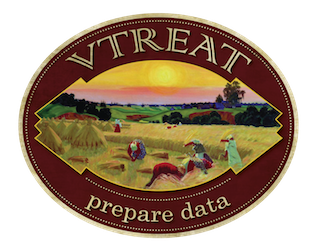
Source: https://github.com/WinVector/pyvtreat

## Training Data

In [42]:
X_data_vt = X_data.copy()
y_data_vt = y_data.copy()

X_train, X_test, y_train, y_test = train_test_split(X_data_vt, y_data_vt, test_size=0.2, random_state=1337)

## Treatment

In [43]:
plan = vtreat.BinomialOutcomeTreatment(outcome_target=True)
X_train_vt = plan.fit_transform(X_train, y_train)
y_train_vt = y_train

X_test_vt  = plan.transform(X_test)
y_test_vt  = y_test
X_train_vt.dtypes

MONTH                                  float64
DAY_OF_WEEK                            float64
SCHEDULED_DEPARTURE                    float64
SCHEDULED_ARRIVAL                      float64
SCHEDULED_TIME                         float64
AIRLINE_logit_code                     float64
AIRLINE_prevalence_code                float64
ORIGIN_AIRPORT_logit_code              float64
ORIGIN_AIRPORT_prevalence_code         float64
DESTINATION_AIRPORT_logit_code         float64
DESTINATION_AIRPORT_prevalence_code    float64
dtype: object

## Fit Model

In [44]:
catModel = cat.CatBoostClassifier(iterations=500, 
                          depth=6, 
                          learning_rate=0.1, 
                          early_stopping_rounds=5,
                          loss_function='Logloss')

In [45]:
X_train_cb, X_val_cb, y_train_cb, y_val_cb = \
    train_test_split(X_train_vt, y_train_vt, test_size=0.2, random_state=1337)

In [46]:
cat_idx = X_train_cb.columns.get_indexer(X_train_cb.select_dtypes('object').columns)

train_pool = cat.Pool(X_train_cb, y_train_cb, cat_features=cat_idx)
val_pool   = cat.Pool(X_val_cb, y_val_cb, cat_features=cat_idx)
test_pool  = cat.Pool(X_test_vt, cat_features=cat_idx) 

In [47]:
catModel.fit(train_pool, eval_set=val_pool)

0:	learn: 0.6899663	test: 0.6899009	best: 0.6899009 (0)	total: 283ms	remaining: 2m 21s
1:	learn: 0.6872954	test: 0.6871976	best: 0.6871976 (1)	total: 553ms	remaining: 2m 17s
2:	learn: 0.6850817	test: 0.6849282	best: 0.6849282 (2)	total: 804ms	remaining: 2m 13s
3:	learn: 0.6832539	test: 0.6830553	best: 0.6830553 (3)	total: 1.04s	remaining: 2m 8s
4:	learn: 0.6817262	test: 0.6815084	best: 0.6815084 (4)	total: 1.3s	remaining: 2m 8s
5:	learn: 0.6804622	test: 0.6802065	best: 0.6802065 (5)	total: 1.55s	remaining: 2m 7s
6:	learn: 0.6793243	test: 0.6790323	best: 0.6790323 (6)	total: 1.77s	remaining: 2m 4s
7:	learn: 0.6783251	test: 0.6779959	best: 0.6779959 (7)	total: 2.01s	remaining: 2m 3s
8:	learn: 0.6774592	test: 0.6771214	best: 0.6771214 (8)	total: 2.24s	remaining: 2m 2s
9:	learn: 0.6767380	test: 0.6763722	best: 0.6763722 (9)	total: 2.49s	remaining: 2m 2s
10:	learn: 0.6760729	test: 0.6756980	best: 0.6756980 (10)	total: 2.74s	remaining: 2m 1s
11:	learn: 0.6754488	test: 0.6750690	best: 0.67506

93:	learn: 0.6638573	test: 0.6633814	best: 0.6633814 (93)	total: 23s	remaining: 1m 39s
94:	learn: 0.6638036	test: 0.6633339	best: 0.6633339 (94)	total: 23.3s	remaining: 1m 39s
95:	learn: 0.6637251	test: 0.6632523	best: 0.6632523 (95)	total: 23.6s	remaining: 1m 39s
96:	learn: 0.6636647	test: 0.6631996	best: 0.6631996 (96)	total: 23.9s	remaining: 1m 39s
97:	learn: 0.6635588	test: 0.6630951	best: 0.6630951 (97)	total: 24.2s	remaining: 1m 39s
98:	learn: 0.6635323	test: 0.6630710	best: 0.6630710 (98)	total: 24.5s	remaining: 1m 39s
99:	learn: 0.6634804	test: 0.6630264	best: 0.6630264 (99)	total: 24.9s	remaining: 1m 39s
100:	learn: 0.6634365	test: 0.6629827	best: 0.6629827 (100)	total: 25.1s	remaining: 1m 39s
101:	learn: 0.6633788	test: 0.6629295	best: 0.6629295 (101)	total: 25.4s	remaining: 1m 39s
102:	learn: 0.6633129	test: 0.6628602	best: 0.6628602 (102)	total: 25.7s	remaining: 1m 39s
103:	learn: 0.6632439	test: 0.6628030	best: 0.6628030 (103)	total: 26s	remaining: 1m 38s
104:	learn: 0.663

184:	learn: 0.6599168	test: 0.6598594	best: 0.6598594 (184)	total: 46s	remaining: 1m 18s
185:	learn: 0.6598973	test: 0.6598436	best: 0.6598436 (185)	total: 46.2s	remaining: 1m 18s
186:	learn: 0.6598501	test: 0.6598021	best: 0.6598021 (186)	total: 46.5s	remaining: 1m 17s
187:	learn: 0.6598116	test: 0.6597686	best: 0.6597686 (187)	total: 46.7s	remaining: 1m 17s
188:	learn: 0.6597788	test: 0.6597412	best: 0.6597412 (188)	total: 47s	remaining: 1m 17s
189:	learn: 0.6597496	test: 0.6597220	best: 0.6597220 (189)	total: 47.2s	remaining: 1m 17s
190:	learn: 0.6597194	test: 0.6596942	best: 0.6596942 (190)	total: 47.4s	remaining: 1m 16s
191:	learn: 0.6596908	test: 0.6596744	best: 0.6596744 (191)	total: 47.6s	remaining: 1m 16s
192:	learn: 0.6596560	test: 0.6596402	best: 0.6596402 (192)	total: 47.9s	remaining: 1m 16s
193:	learn: 0.6596210	test: 0.6596077	best: 0.6596077 (193)	total: 48.1s	remaining: 1m 15s
194:	learn: 0.6595884	test: 0.6595750	best: 0.6595750 (194)	total: 48.3s	remaining: 1m 15s
195

276:	learn: 0.6575052	test: 0.6578147	best: 0.6578147 (276)	total: 1m 6s	remaining: 53.8s
277:	learn: 0.6574869	test: 0.6578008	best: 0.6578008 (277)	total: 1m 7s	remaining: 53.6s
278:	learn: 0.6574228	test: 0.6577390	best: 0.6577390 (278)	total: 1m 7s	remaining: 53.3s
279:	learn: 0.6573978	test: 0.6577171	best: 0.6577171 (279)	total: 1m 7s	remaining: 53s
280:	learn: 0.6573722	test: 0.6576933	best: 0.6576933 (280)	total: 1m 7s	remaining: 52.8s
281:	learn: 0.6573445	test: 0.6576684	best: 0.6576684 (281)	total: 1m 7s	remaining: 52.5s
282:	learn: 0.6573133	test: 0.6576448	best: 0.6576448 (282)	total: 1m 8s	remaining: 52.3s
283:	learn: 0.6572861	test: 0.6576225	best: 0.6576225 (283)	total: 1m 8s	remaining: 52s
284:	learn: 0.6572533	test: 0.6575863	best: 0.6575863 (284)	total: 1m 8s	remaining: 51.7s
285:	learn: 0.6572265	test: 0.6575608	best: 0.6575608 (285)	total: 1m 8s	remaining: 51.5s
286:	learn: 0.6572104	test: 0.6575484	best: 0.6575484 (286)	total: 1m 9s	remaining: 51.2s
287:	learn: 0.

367:	learn: 0.6556272	test: 0.6562842	best: 0.6562842 (367)	total: 1m 27s	remaining: 31.3s
368:	learn: 0.6555998	test: 0.6562638	best: 0.6562638 (368)	total: 1m 27s	remaining: 31s
369:	learn: 0.6555741	test: 0.6562381	best: 0.6562381 (369)	total: 1m 27s	remaining: 30.8s
370:	learn: 0.6555583	test: 0.6562272	best: 0.6562272 (370)	total: 1m 27s	remaining: 30.5s
371:	learn: 0.6555403	test: 0.6562137	best: 0.6562137 (371)	total: 1m 28s	remaining: 30.3s
372:	learn: 0.6555216	test: 0.6561967	best: 0.6561967 (372)	total: 1m 28s	remaining: 30.1s
373:	learn: 0.6555093	test: 0.6561955	best: 0.6561955 (373)	total: 1m 28s	remaining: 29.9s
374:	learn: 0.6554822	test: 0.6561716	best: 0.6561716 (374)	total: 1m 28s	remaining: 29.6s
375:	learn: 0.6554689	test: 0.6561653	best: 0.6561653 (375)	total: 1m 29s	remaining: 29.4s
376:	learn: 0.6554526	test: 0.6561542	best: 0.6561542 (376)	total: 1m 29s	remaining: 29.2s
377:	learn: 0.6554318	test: 0.6561364	best: 0.6561364 (377)	total: 1m 29s	remaining: 29s
378

458:	learn: 0.6541561	test: 0.6552105	best: 0.6552105 (458)	total: 1m 48s	remaining: 9.66s
459:	learn: 0.6541471	test: 0.6552048	best: 0.6552048 (459)	total: 1m 48s	remaining: 9.42s
460:	learn: 0.6541320	test: 0.6551955	best: 0.6551955 (460)	total: 1m 48s	remaining: 9.19s
461:	learn: 0.6541185	test: 0.6551888	best: 0.6551888 (461)	total: 1m 48s	remaining: 8.95s
462:	learn: 0.6541037	test: 0.6551766	best: 0.6551766 (462)	total: 1m 49s	remaining: 8.71s
463:	learn: 0.6540933	test: 0.6551739	best: 0.6551739 (463)	total: 1m 49s	remaining: 8.47s
464:	learn: 0.6540815	test: 0.6551671	best: 0.6551671 (464)	total: 1m 49s	remaining: 8.23s
465:	learn: 0.6540709	test: 0.6551662	best: 0.6551662 (465)	total: 1m 49s	remaining: 8s
466:	learn: 0.6540558	test: 0.6551548	best: 0.6551548 (466)	total: 1m 49s	remaining: 7.76s
467:	learn: 0.6540420	test: 0.6551456	best: 0.6551456 (467)	total: 1m 50s	remaining: 7.53s
468:	learn: 0.6540321	test: 0.6551404	best: 0.6551404 (468)	total: 1m 50s	remaining: 7.29s
46

## Predict Model

In [48]:
pred = catModel.predict(test_pool)

In [49]:
acc = measureErrors(pred, y_test)
resultsDF.loc['VTreat'] = [acc, len(X_train_vt.columns)]

Accuracy 0.609625
Confusion Matrix
[[118472  74563]
 [ 81587 125378]]
Classification Report
              precision    recall  f1-score   support

           0       0.61      0.59      0.60    200059
           1       0.61      0.63      0.62    199941

    accuracy                           0.61    400000
   macro avg       0.61      0.61      0.61    400000
weighted avg       0.61      0.61      0.61    400000



## Importance

In [50]:
importanceDF = pd.DataFrame(columns=['Feature', 'Importance'])
importanceDF['Feature'] = X_train_vt.columns
importanceDF['Importance'] = catModel.feature_importances_
importanceDF = importanceDF.sort_values('Importance', ascending=False)
importanceDF

,Feature,Importance
0,MONTH,20.395749
2,SCHEDULED_DEPARTURE,14.485506
5,AIRLINE_logit_code,10.415165
6,AIRLINE_prevalence_code,9.927404
10,DESTINATION_AIRPORT_prevalence_code,7.869856
7,ORIGIN_AIRPORT_logit_code,7.116972
1,DAY_OF_WEEK,7.038792
8,ORIGIN_AIRPORT_prevalence_code,6.086386
3,SCHEDULED_ARRIVAL,5.910888
9,DESTINATION_AIRPORT_logit_code,5.725249


# Featuretools
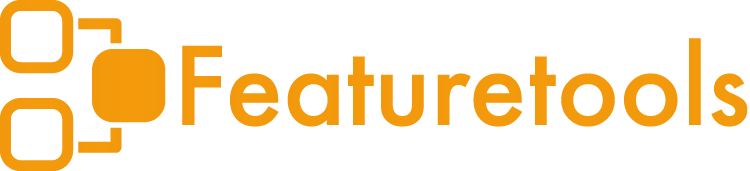
Source:  https://www.featuretools.com/

In [51]:
X_data_ft = X_data.copy()
y_data_ft = y_data.copy()

es = ft.EntitySet(id='delay_data')

## Flights

In [52]:
es = es.entity_from_dataframe(entity_id='flights', 
                              dataframe=X_data_ft,
                              index='INDEX')
es

2019-10-23 19:41:34,030 featuretools.entityset - WARNING    index INDEX not found in dataframe, creating new integer column


Entityset: delay_data
  Entities:
    flights [Rows: 2000000, Columns: 11]
  Relationships:
    No relationships

In [53]:
es['flights'].variables

[<Variable: INDEX (dtype = index)>,
 <Variable: MONTH (dtype = numeric)>,
 <Variable: DAY_OF_WEEK (dtype = numeric)>,
 <Variable: AIRLINE (dtype = categorical)>,
 <Variable: ORIGIN_AIRPORT (dtype = categorical)>,
 <Variable: DESTINATION_AIRPORT (dtype = categorical)>,
 <Variable: SCHEDULED_DEPARTURE (dtype = numeric)>,
 <Variable: SCHEDULED_ARRIVAL (dtype = numeric)>,
 <Variable: SCHEDULED_TIME (dtype = numeric)>,
 <Variable: DISTANCE (dtype = numeric)>,
 <Variable: CANCELLED (dtype = numeric)>]

## Airlines

In [54]:
es = es.entity_from_dataframe(entity_id='airlines',
                             dataframe=airlineDF,
                             index='IATA_CODE')
es

Entityset: delay_data
  Entities:
    flights [Rows: 2000000, Columns: 11]
    airlines [Rows: 14, Columns: 1]
  Relationships:
    No relationships

## Airports

In [55]:
es = es.entity_from_dataframe(entity_id='dep_airports',
                             dataframe=airportDF,
                             index='IATA_CODE')
es = es.entity_from_dataframe(entity_id='arr_airports',
                             dataframe=airportDF,
                             index='IATA_CODE')
es

Entityset: delay_data
  Entities:
    flights [Rows: 2000000, Columns: 11]
    airlines [Rows: 14, Columns: 1]
    dep_airports [Rows: 322, Columns: 1]
    arr_airports [Rows: 322, Columns: 1]
  Relationships:
    No relationships

## Relationships

In [56]:
rel_airline_flight = ft.Relationship(es['airlines']['IATA_CODE'], es['flights']['AIRLINE'])
rel_dep_flight = ft.Relationship(es['dep_airports']['IATA_CODE'], es['flights']['ORIGIN_AIRPORT'])
rel_arr_flight = ft.Relationship(es['arr_airports']['IATA_CODE'], es['flights']['DESTINATION_AIRPORT'])

es.add_relationship(rel_airline_flight)
es.add_relationship(rel_dep_flight)
es.add_relationship(rel_arr_flight)
es

Entityset: delay_data
  Entities:
    flights [Rows: 2000000, Columns: 11]
    airlines [Rows: 14, Columns: 1]
    dep_airports [Rows: 322, Columns: 1]
    arr_airports [Rows: 322, Columns: 1]
  Relationships:
    flights.AIRLINE -> airlines.IATA_CODE
    flights.ORIGIN_AIRPORT -> dep_airports.IATA_CODE
    flights.DESTINATION_AIRPORT -> arr_airports.IATA_CODE

## Deep Feature Synthesis

In [57]:
X_train_ft, X_train_features = ft.dfs(entityset=es, target_entity='flights', 
    ignore_variables={'flights': ['ARRIVAL_DELAY', 'CLASS']}) 

X_train_ft = X_train_ft.reset_index(drop=True)
y_train_ft = y_data_ft

In [58]:
X_train_features

[<Feature: MONTH>,
 <Feature: DAY_OF_WEEK>,
 <Feature: AIRLINE>,
 <Feature: ORIGIN_AIRPORT>,
 <Feature: DESTINATION_AIRPORT>,
 <Feature: SCHEDULED_DEPARTURE>,
 <Feature: SCHEDULED_ARRIVAL>,
 <Feature: SCHEDULED_TIME>,
 <Feature: DISTANCE>,
 <Feature: CANCELLED>,
 <Feature: airlines.SUM(flights.SCHEDULED_TIME)>,
 <Feature: airlines.SUM(flights.SCHEDULED_DEPARTURE)>,
 <Feature: airlines.SUM(flights.DAY_OF_WEEK)>,
 <Feature: airlines.SUM(flights.MONTH)>,
 <Feature: airlines.SUM(flights.CANCELLED)>,
 <Feature: airlines.SUM(flights.SCHEDULED_ARRIVAL)>,
 <Feature: airlines.SUM(flights.DISTANCE)>,
 <Feature: airlines.STD(flights.SCHEDULED_TIME)>,
 <Feature: airlines.STD(flights.SCHEDULED_DEPARTURE)>,
 <Feature: airlines.STD(flights.DAY_OF_WEEK)>,
 <Feature: airlines.STD(flights.MONTH)>,
 <Feature: airlines.STD(flights.CANCELLED)>,
 <Feature: airlines.STD(flights.SCHEDULED_ARRIVAL)>,
 <Feature: airlines.STD(flights.DISTANCE)>,
 <Feature: airlines.MAX(flights.SCHEDULED_TIME)>,
 <Feature: airlin

In [59]:
X_train_ft.head()

,MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,DISTANCE,CANCELLED,...,arr_airports.MEAN(flights.DAY_OF_WEEK),arr_airports.MEAN(flights.MONTH),arr_airports.MEAN(flights.CANCELLED),arr_airports.MEAN(flights.SCHEDULED_ARRIVAL),arr_airports.MEAN(flights.DISTANCE),arr_airports.COUNT(flights),arr_airports.NUM_UNIQUE(flights.AIRLINE),arr_airports.NUM_UNIQUE(flights.ORIGIN_AIRPORT),arr_airports.MODE(flights.AIRLINE),arr_airports.MODE(flights.ORIGIN_AIRPORT)
0,8,4,AS,DEN,SEA,1850,2035,165.0,1024,0,...,3.935870,6.465381,0,1522.175986,1261.487513,41884,11,73,AS,LAX
1,5,2,F9,DEN,DFW,600,850,110.0,641,0,...,3.928983,5.991317,0,1429.090435,786.359778,87754,11,149,AA,ORD
2,2,4,WN,BWI,BNA,2005,2110,125.0,587,0,...,3.886878,6.235377,0,1515.816338,665.210500,17848,10,45,WN,ORD
3,11,7,WN,ATL,CMH,1555,1725,90.0,447,0,...,3.861397,6.192957,0,1591.777828,670.856641,8831,8,29,WN,ORD
4,4,4,WN,OAK,MDW,1410,2015,245.0,1844,0,...,3.909788,6.238382,0,1470.949676,805.390503,29608,5,69,WN,ATL


## Training Data

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_train_ft, y_train_ft, test_size=0.2, random_state=1337)

## Fit Model

In [61]:
catModel = cat.CatBoostClassifier(iterations=500, 
                          depth=6, 
                          learning_rate=0.1, 
                          early_stopping_rounds=5,
                          loss_function='Logloss')

In [62]:
X_train_cb, X_val_cb, y_train_cb, y_val_cb = \
    train_test_split(X_train_ft, y_train_ft, test_size=0.2, random_state=1337)

In [63]:
cat_idx = X_train_cb.columns.get_indexer(X_train_cb.select_dtypes('object').columns)

train_pool = cat.Pool(X_train_cb, y_train_cb, cat_features=cat_idx)
val_pool   = cat.Pool(X_val_cb, y_val_cb, cat_features=cat_idx)
test_pool  = cat.Pool(X_test, cat_features=cat_idx) 

In [64]:
catModel.fit(train_pool, eval_set=val_pool)

0:	learn: 0.6899651	test: 0.6900158	best: 0.6900158 (0)	total: 2.99s	remaining: 24m 51s
1:	learn: 0.6872892	test: 0.6873696	best: 0.6873696 (1)	total: 5.05s	remaining: 20m 58s
2:	learn: 0.6851717	test: 0.6852889	best: 0.6852889 (2)	total: 6.75s	remaining: 18m 39s
3:	learn: 0.6833259	test: 0.6834710	best: 0.6834710 (3)	total: 8.6s	remaining: 17m 46s
4:	learn: 0.6816658	test: 0.6818414	best: 0.6818414 (4)	total: 11s	remaining: 18m 13s
5:	learn: 0.6803461	test: 0.6805505	best: 0.6805505 (5)	total: 12.7s	remaining: 17m 28s
6:	learn: 0.6791896	test: 0.6794211	best: 0.6794211 (6)	total: 14.3s	remaining: 16m 46s
7:	learn: 0.6781822	test: 0.6784288	best: 0.6784288 (7)	total: 16.2s	remaining: 16m 34s
8:	learn: 0.6772487	test: 0.6775019	best: 0.6775019 (8)	total: 18.2s	remaining: 16m 31s
9:	learn: 0.6764607	test: 0.6767191	best: 0.6767191 (9)	total: 19.6s	remaining: 15m 59s
10:	learn: 0.6757486	test: 0.6760181	best: 0.6760181 (10)	total: 21.3s	remaining: 15m 45s
11:	learn: 0.6750201	test: 0.6753

92:	learn: 0.6603673	test: 0.6604327	best: 0.6604327 (92)	total: 2m 31s	remaining: 11m 1s
93:	learn: 0.6602743	test: 0.6603508	best: 0.6603508 (93)	total: 2m 32s	remaining: 11m
94:	learn: 0.6602065	test: 0.6602951	best: 0.6602951 (94)	total: 2m 34s	remaining: 10m 58s
95:	learn: 0.6601575	test: 0.6602474	best: 0.6602474 (95)	total: 2m 36s	remaining: 10m 57s
96:	learn: 0.6600955	test: 0.6601918	best: 0.6601918 (96)	total: 2m 37s	remaining: 10m 55s
97:	learn: 0.6600553	test: 0.6601592	best: 0.6601592 (97)	total: 2m 39s	remaining: 10m 53s
98:	learn: 0.6600004	test: 0.6601078	best: 0.6601078 (98)	total: 2m 40s	remaining: 10m 51s
99:	learn: 0.6599336	test: 0.6600477	best: 0.6600477 (99)	total: 2m 42s	remaining: 10m 50s
100:	learn: 0.6598275	test: 0.6599246	best: 0.6599246 (100)	total: 2m 43s	remaining: 10m 47s
101:	learn: 0.6597668	test: 0.6598698	best: 0.6598698 (101)	total: 2m 45s	remaining: 10m 45s
102:	learn: 0.6597318	test: 0.6598393	best: 0.6598393 (102)	total: 2m 47s	remaining: 10m 43

182:	learn: 0.6560055	test: 0.6563977	best: 0.6563977 (182)	total: 5m	remaining: 8m 41s
183:	learn: 0.6559681	test: 0.6563703	best: 0.6563703 (183)	total: 5m 3s	remaining: 8m 40s
184:	learn: 0.6559421	test: 0.6563506	best: 0.6563506 (184)	total: 5m 4s	remaining: 8m 38s
185:	learn: 0.6558984	test: 0.6563159	best: 0.6563159 (185)	total: 5m 6s	remaining: 8m 37s
186:	learn: 0.6558740	test: 0.6562981	best: 0.6562981 (186)	total: 5m 8s	remaining: 8m 35s
187:	learn: 0.6558493	test: 0.6562764	best: 0.6562764 (187)	total: 5m 10s	remaining: 8m 34s
188:	learn: 0.6558218	test: 0.6562564	best: 0.6562564 (188)	total: 5m 11s	remaining: 8m 33s
189:	learn: 0.6557915	test: 0.6562301	best: 0.6562301 (189)	total: 5m 13s	remaining: 8m 31s
190:	learn: 0.6557555	test: 0.6561954	best: 0.6561954 (190)	total: 5m 15s	remaining: 8m 29s
191:	learn: 0.6557131	test: 0.6561555	best: 0.6561555 (191)	total: 5m 16s	remaining: 8m 28s
192:	learn: 0.6556811	test: 0.6561297	best: 0.6561297 (192)	total: 5m 18s	remaining: 8m 

272:	learn: 0.6533845	test: 0.6541348	best: 0.6541348 (272)	total: 7m 36s	remaining: 6m 19s
273:	learn: 0.6533501	test: 0.6541086	best: 0.6541086 (273)	total: 7m 37s	remaining: 6m 17s
274:	learn: 0.6533303	test: 0.6540966	best: 0.6540966 (274)	total: 7m 39s	remaining: 6m 15s
275:	learn: 0.6533050	test: 0.6540767	best: 0.6540767 (275)	total: 7m 41s	remaining: 6m 14s
276:	learn: 0.6532776	test: 0.6540481	best: 0.6540481 (276)	total: 7m 42s	remaining: 6m 12s
277:	learn: 0.6532424	test: 0.6540121	best: 0.6540121 (277)	total: 7m 44s	remaining: 6m 10s
278:	learn: 0.6532258	test: 0.6539995	best: 0.6539995 (278)	total: 7m 45s	remaining: 6m 9s
279:	learn: 0.6531990	test: 0.6539728	best: 0.6539728 (279)	total: 7m 47s	remaining: 6m 7s
280:	learn: 0.6531768	test: 0.6539572	best: 0.6539572 (280)	total: 7m 49s	remaining: 6m 5s
281:	learn: 0.6531603	test: 0.6539464	best: 0.6539464 (281)	total: 7m 50s	remaining: 6m 3s
282:	learn: 0.6531273	test: 0.6539071	best: 0.6539071 (282)	total: 7m 51s	remaining:

362:	learn: 0.6514229	test: 0.6524925	best: 0.6524925 (362)	total: 9m 57s	remaining: 3m 45s
363:	learn: 0.6514050	test: 0.6524798	best: 0.6524798 (363)	total: 9m 59s	remaining: 3m 43s
364:	learn: 0.6513665	test: 0.6524409	best: 0.6524409 (364)	total: 10m 1s	remaining: 3m 42s
365:	learn: 0.6513470	test: 0.6524251	best: 0.6524251 (365)	total: 10m 2s	remaining: 3m 40s
366:	learn: 0.6513249	test: 0.6524004	best: 0.6524004 (366)	total: 10m 4s	remaining: 3m 38s
367:	learn: 0.6513096	test: 0.6523906	best: 0.6523906 (367)	total: 10m 5s	remaining: 3m 37s
368:	learn: 0.6512834	test: 0.6523676	best: 0.6523676 (368)	total: 10m 7s	remaining: 3m 35s
369:	learn: 0.6512614	test: 0.6523481	best: 0.6523481 (369)	total: 10m 8s	remaining: 3m 33s
370:	learn: 0.6512443	test: 0.6523365	best: 0.6523365 (370)	total: 10m 10s	remaining: 3m 32s
371:	learn: 0.6512376	test: 0.6523313	best: 0.6523313 (371)	total: 10m 12s	remaining: 3m 30s
372:	learn: 0.6512183	test: 0.6523193	best: 0.6523193 (372)	total: 10m 13s	rem

451:	learn: 0.6498980	test: 0.6512940	best: 0.6512940 (451)	total: 12m 20s	remaining: 1m 18s
452:	learn: 0.6498774	test: 0.6512805	best: 0.6512805 (452)	total: 12m 21s	remaining: 1m 16s
453:	learn: 0.6498559	test: 0.6512623	best: 0.6512623 (453)	total: 12m 23s	remaining: 1m 15s
454:	learn: 0.6498181	test: 0.6512235	best: 0.6512235 (454)	total: 12m 25s	remaining: 1m 13s
455:	learn: 0.6498027	test: 0.6512127	best: 0.6512127 (455)	total: 12m 26s	remaining: 1m 12s
456:	learn: 0.6497814	test: 0.6511968	best: 0.6511968 (456)	total: 12m 28s	remaining: 1m 10s
457:	learn: 0.6497672	test: 0.6511837	best: 0.6511837 (457)	total: 12m 29s	remaining: 1m 8s
458:	learn: 0.6497538	test: 0.6511739	best: 0.6511739 (458)	total: 12m 31s	remaining: 1m 7s
459:	learn: 0.6497413	test: 0.6511627	best: 0.6511627 (459)	total: 12m 33s	remaining: 1m 5s
460:	learn: 0.6497316	test: 0.6511581	best: 0.6511581 (460)	total: 12m 34s	remaining: 1m 3s
461:	learn: 0.6497204	test: 0.6511510	best: 0.6511510 (461)	total: 12m 36s

## Predict Model

In [65]:
pred = catModel.predict(test_pool)

In [66]:
acc = measureErrors(pred, y_test)
resultsDF.loc['Featuretools'] = [acc, len(X_train_ft.columns)]

Accuracy 0.6176
Confusion Matrix
[[121209  74110]
 [ 78850 125831]]
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.61      0.61    200059
           1       0.61      0.63      0.62    199941

    accuracy                           0.62    400000
   macro avg       0.62      0.62      0.62    400000
weighted avg       0.62      0.62      0.62    400000



## Importance

In [67]:
importanceDF = pd.DataFrame(columns=['Feature', 'Importance'])
importanceDF['Feature'] = X_train_cb.columns
importanceDF['Importance'] = catModel.feature_importances_
importanceDF = importanceDF.sort_values('Importance', ascending=False)
importanceDF

,Feature,Importance
0,MONTH,22.132844
5,SCHEDULED_DEPARTURE,13.605094
1,DAY_OF_WEEK,7.101584
6,SCHEDULED_ARRIVAL,5.143588
7,SCHEDULED_TIME,4.045624
2,AIRLINE,3.359086
8,DISTANCE,3.046576
3,ORIGIN_AIRPORT,2.850201
46,airlines.MEAN(flights.SCHEDULED_DEPARTURE),2.693193
56,airlines.MODE(flights.ORIGIN_AIRPORT),2.264488


# Results
* Overall
 * We're better than random (50%), but not by a "large" amount
 * Feature engineering on this dataset didn't have a large payback -- in two cases we did worse
* Next step?
 * More / different feature engineering?
 * More data?
   * More Rows
   * More Columns
 * More complex model?  
   * Ensembles / Stacking
   * Deep Feed Forward Network
 * Regularization on CatBoost?
 * Feature Selection?
 * Apply PCA?

In [111]:
resultsDF.sort_values('Accuracy', ascending=False)

,Accuracy,Features
Featuretools,0.617600,151.0
Baseline,0.615613,10.0
FeatureEngine,0.614620,26.0
VTreat,0.609625,11.0


# Conclusion & Tips
* Helpful with bias in models
 * Adds complexity to model
 * Extract the most from your data
* Common Approaches
 * Roll your own
   * Helper libraries (Feature-engine)
   * Time consuming
   * Leverage your instincts
   * Be Creative
   * Interactions
 * VTreat
   * Compact
   * Does a decent first pass
   * Can do mean encoding!!
   * Handles missing data!!
 * Featuretools
   * Think like a database 
   * Exploit relationships to generate features
   * Can drive up features quite a bit 
   * Consider pairing with feature selection
 * Auto-ML Plays (Not featured)
   * TPot
   * H2O
   * DataRobot
* Don't use feature engineering for things best left for cross-validation:
 * Scaling 
 * Normalization

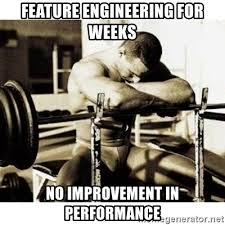